In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load data
data = pd.read_csv("imbalancedtask1reddit.csv")

In [4]:
data = data.drop(["Unnamed: 0"], axis = 1)

In [5]:
data = data.dropna()

In [6]:
# Preprocess text
data["chat1"] = data["chat1"].str.lower()
data["chat1"] = data["chat1"].str.replace("[^\w\s]", "")
data["chat1"] = data["chat1"].str.replace("\d+", "")
data["chat1"] = data["chat1"].str.strip()
data["chat1"] = data["chat1"].str.split()
data["chat2"] = data["chat2"].str.lower()
data["chat2"] = data["chat2"].str.replace("[^\w\s]", "")
data["chat2"] = data["chat2"].str.replace("\d+", "")
data["chat2"] = data["chat2"].str.strip()
data["chat2"] = data["chat2"].str.split()

<ipython-input-6-9c96dabc18ce>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data["chat1"] = data["chat1"].str.replace("[^\w\s]", "")
<ipython-input-6-9c96dabc18ce>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data["chat1"] = data["chat1"].str.replace("\d+", "")
<ipython-input-6-9c96dabc18ce>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data["chat2"] = data["chat2"].str.replace("[^\w\s]", "")
<ipython-input-6-9c96dabc18ce>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data["chat2"] = data["chat2"].str.replace("\d+", "")


In [7]:
# Remove stop words
stop_words = set(stopwords.words('english'))
data["chat1"] = data["chat1"].apply(lambda x: [word for word in x if word not in stop_words])
data["chat2"] = data["chat2"].apply(lambda x: [word for word in x if word not in stop_words])

In [8]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["chat1"])
sequences1 = tokenizer.texts_to_sequences(data["chat1"])
tokenizer.fit_on_texts(data["chat2"])
sequences2 = tokenizer.texts_to_sequences(data["chat2"])

In [9]:
# Pad sequences
maxlen = 100
padded_sequences1 = pad_sequences(sequences1, maxlen=maxlen)
padded_sequences2 = pad_sequences(sequences2, maxlen=maxlen)

In [10]:
padd = np.concatenate([padded_sequences1, padded_sequences2], axis = 1)

In [11]:
# Encode labels
labels = pd.get_dummies(data["label"]).values

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(padd, labels, test_size=0.2, random_state=42)

In [13]:
# Define model
model = Sequential()
model.add(Embedding(2 * (len(tokenizer.word_index) + 1), 128, input_length=2 * maxlen))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(2, activation="softmax"))

In [14]:
# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
7/7 [==============================] - 9s 462ms/step - loss: 0.6305 - accuracy: 0.7076 - val_loss: 0.6380 - val_accuracy: 0.6726
Epoch 2/10
7/7 [==============================] - 1s 211ms/step - loss: 0.5657 - accuracy: 0.7522 - val_loss: 0.6709 - val_accuracy: 0.6726
Epoch 3/10
7/7 [==============================] - 1s 208ms/step - loss: 0.5238 - accuracy: 0.7522 - val_loss: 0.6391 - val_accuracy: 0.6726
Epoch 4/10
7/7 [==============================] - 1s 205ms/step - loss: 0.4266 - accuracy: 0.7522 - val_loss: 0.7555 - val_accuracy: 0.6726
Epoch 5/10
7/7 [==============================] - 1s 205ms/step - loss: 0.2173 - accuracy: 0.9263 - val_loss: 0.6930 - val_accuracy: 0.6726
Epoch 6/10
7/7 [==============================] - 1s 205ms/step - loss: 0.1324 - accuracy: 0.9710 - val_loss: 0.6962 - val_accuracy: 0.6991
Epoch 7/10
7/7 [==============================] - 1s 205ms/step - loss: 0.0603 - accuracy: 0.9933 - val_loss: 1.0855 - val_accuracy: 0.6814
Epoch 8/10
7/7 [====

In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

4/4 [==============================] - 2s 44ms/step


In [17]:
y_test = np.argmax(y_test, axis=1)

In [18]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.91      0.78        76
           1       0.46      0.16      0.24        37

    accuracy                           0.66       113
   macro avg       0.58      0.54      0.51       113
weighted avg       0.62      0.66      0.61       113

[[69  7]
 [31  6]]


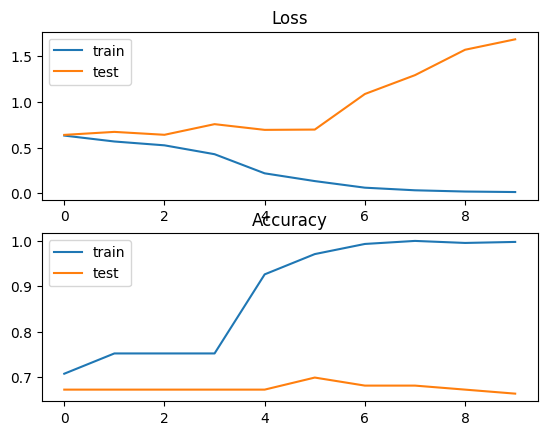

In [19]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()